# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [59]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import DateType, IntegerType
from datetime import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/06 21:52:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("data/mini_sparkify_event_data.json")
df.persist()

df_pandas = df.toPandas()

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
null_counts = df.agg(*[sum(when(col(c).isNull(), 1)).alias(c) for c in df.columns]).collect()[0].asDict()
null_counts

{'artist': 58392,
 'auth': None,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': None,
 'lastName': 8346,
 'length': 58392,
 'level': None,
 'location': 8346,
 'method': None,
 'page': None,
 'registration': 8346,
 'sessionId': None,
 'song': 58392,
 'status': None,
 'ts': None,
 'userAgent': 8346,
 'userId': None}

In [7]:
#checking if we have columns with empty values

empty_counts = df.agg(*[sum(when(col(c) == '', 1)).alias(c) for c in df.columns]).collect()[0].asDict()
empty_counts

{'artist': None,
 'auth': None,
 'firstName': None,
 'gender': None,
 'itemInSession': None,
 'lastName': None,
 'length': None,
 'level': None,
 'location': None,
 'method': None,
 'page': None,
 'registration': None,
 'sessionId': None,
 'song': None,
 'status': None,
 'ts': None,
 'userAgent': None,
 'userId': 8346}

In [8]:
#If we are predicting churns, we need the user identification, so i'm dropping all rows with empty userId

df = df.filter(col("userId") != '')

In [9]:
empty_counts = df.agg(*[sum(when(col(c) == '', 1)).alias(c) for c in df.columns]).collect()[0].asDict()
empty_counts

{'artist': None,
 'auth': None,
 'firstName': None,
 'gender': None,
 'itemInSession': None,
 'lastName': None,
 'length': None,
 'level': None,
 'location': None,
 'method': None,
 'page': None,
 'registration': None,
 'sessionId': None,
 'song': None,
 'status': None,
 'ts': None,
 'userAgent': None,
 'userId': None}

In [10]:
df = df.withColumn(
    "registration_date", from_unixtime(col("registration") / 1000, "yyyy-MM-dd")
).withColumn(
    "days_of_membership",
    ((col("ts") - col("registration")) / (1000 * 60 * 60 * 24)).cast(IntegerType())
)

In [11]:
df.selectExpr("min(registration_date)", "max(registration_date)").show()

+----------------------+----------------------+
|min(registration_date)|max(registration_date)|
+----------------------+----------------------+
|            2018-03-18|            2018-11-26|
+----------------------+----------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
w = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)


df = (
    df.withColumn(
        "churn_event",
        when((col("page") == "Cancellation Confirmation"), 1).otherwise(0),
    )
    .withColumn(
        "days_to_churn",
        when(
            (col("churn_event") == 1),
            ((col("ts") - col("registration")) / (1000 * 60 * 60 * 24)).cast(
                IntegerType()
            ),
        ).otherwise(None),
    )
    .withColumn(
        "churn", max("churn_event").over(w)
    )
)


In [13]:
df\
.select("userId")\
.filter(col("churn") == 1)\
.distinct()\
.count()

52

### In the small dataset we have 52 users that churned after they registered.

In [14]:
days_to_churn = df.select("days_to_churn").filter(col("days_to_churn").isNotNull()).toPandas()


days_to_churn.describe()

,days_to_churn
count,52.000000
mean,56.807692
std,36.602817
min,5.000000
25%,30.500000
50%,50.500000
75%,73.500000
max,188.000000


### User take an average of 56.8 days to churn since the registration date.

## Session Count

In [15]:
df.groupby('churn').agg(countDistinct('sessionId').alias('count_session_id')).show()

+-----+----------------+
|churn|count_session_id|
+-----+----------------+
|    1|             468|
|    0|            2110|
+-----+----------------+



## Page Visits

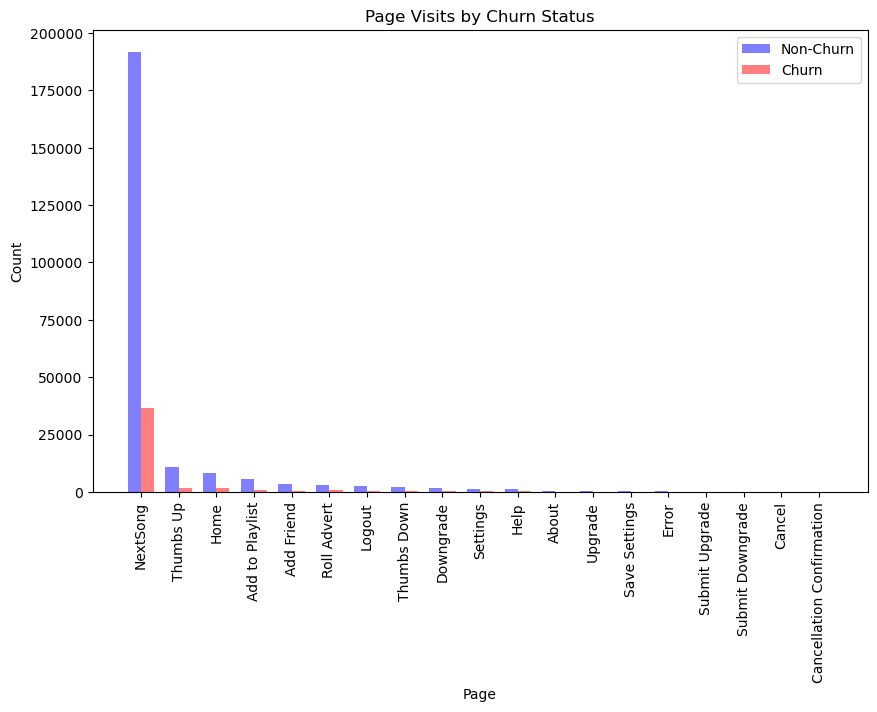

In [16]:
# Set the figure size
# Group by 'page' and 'churn', then count
df_grouped = df.groupby('page', 'churn').count()

# Pivot on 'churn' to create two columns '0' and '1'
df_pages = df_grouped.groupBy('page').pivot('churn').sum('count')

# Rename the columns
df_pages = df_pages.withColumnRenamed('0', 'non_churn_pages').withColumnRenamed('1', 'churn_pages')

# Fill null values with 0
df_pages = df_pages.na.fill(0)

# Order the values
df_pages = df_pages.orderBy(desc('non_churn_pages'), desc('churn_pages'))

# Convert to a pandas DataFrame for plotting
pdf_pages = df_pages.toPandas()

plt.figure(figsize=(10, 6))

# Create an index for each 'page' category
barWidth = 0.35
r1 = np.arange(len(pdf_pages['page']))
r2 = [x + barWidth for x in r1]

# Create a bar plot for non-churn pages
plt.bar(r1, pdf_pages['non_churn_pages'], color='b', width=barWidth, alpha=0.5, label='Non-Churn')

# Create a bar plot for churn pages
plt.bar(r2, pdf_pages['churn_pages'], color='r', width=barWidth, alpha=0.5, label='Churn')

# Set the title and labels
plt.title('Page Visits by Churn Status')
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks([r + barWidth/2 for r in range(len(pdf_pages['page']))], pdf_pages['page'], rotation=90)

plt.legend()

# Show the plot
plt.show()

## Days of Membership

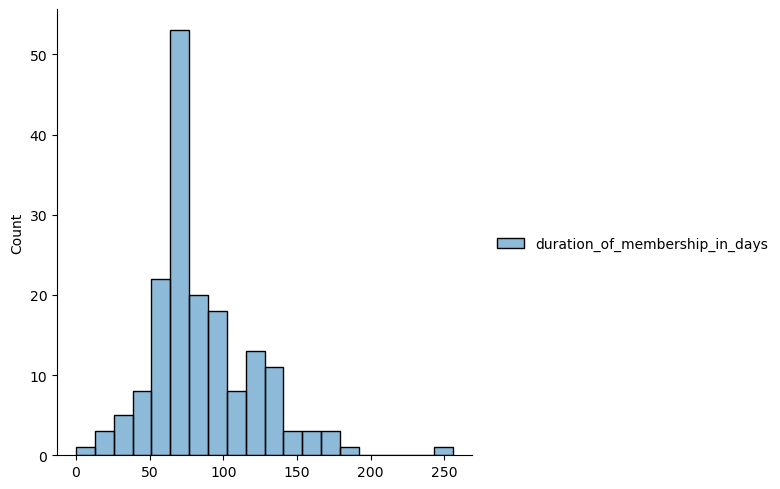

In [17]:
non_churn_membership_in_days = (
    df.filter(col("churn") == 0)
    .groupBy("userId")
    .agg(max("days_of_membership").alias("duration_of_membership_in_days"))
    .distinct()
)

sns.displot(non_churn_membership_in_days.toPandas())

In [18]:
non_churn_membership_in_days.describe().show()

+-------+------------------+------------------------------+
|summary|            userId|duration_of_membership_in_days|
+-------+------------------+------------------------------+
|  count|               173|                           173|
|   mean| 60756.87861271676|             86.14450867052022|
| stddev|110276.04376677399|            35.333081810838095|
|    min|                10|                             0|
|    max|                99|                           256|
+-------+------------------+------------------------------+



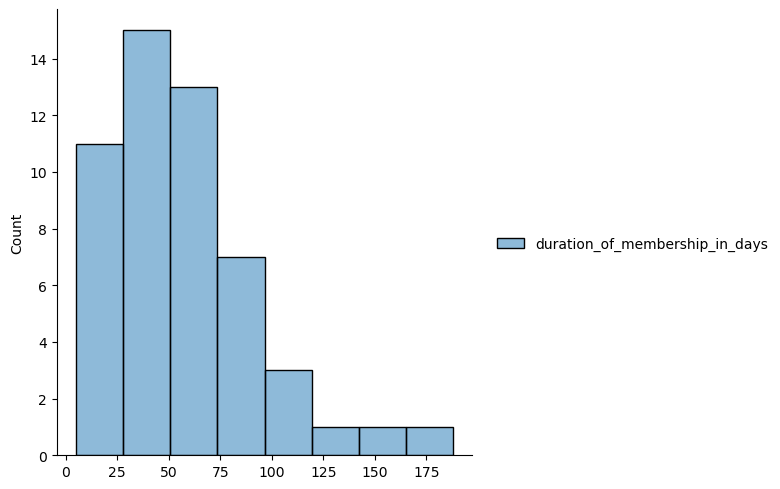

In [19]:
churn_membership_in_days = (
    df
    .filter(col("churn") == 1)
    .groupBy("userId")
    .agg(max("days_of_membership").alias("duration_of_membership_in_days"))
    .distinct()
)

sns.displot(churn_membership_in_days.toPandas())

In [20]:
churn_membership_in_days.describe().show()

+-------+-----------------+------------------------------+
|summary|           userId|duration_of_membership_in_days|
+-------+-----------------+------------------------------+
|  count|               52|                            52|
|   mean|80808.42307692308|             56.80769230769231|
| stddev|86381.67706591172|             36.60281702516868|
|    min|           100001|                             5|
|    max|               87|                           188|
+-------+-----------------+------------------------------+



## Item in Session

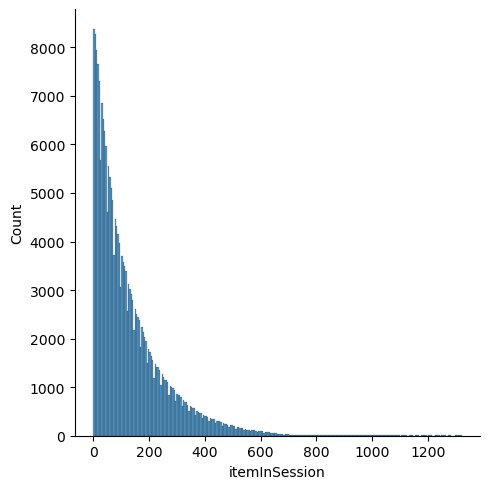

In [21]:
paid_item_in_session = df.filter(col("level") == "paid").toPandas()

sns.displot(paid_item_in_session['itemInSession'])

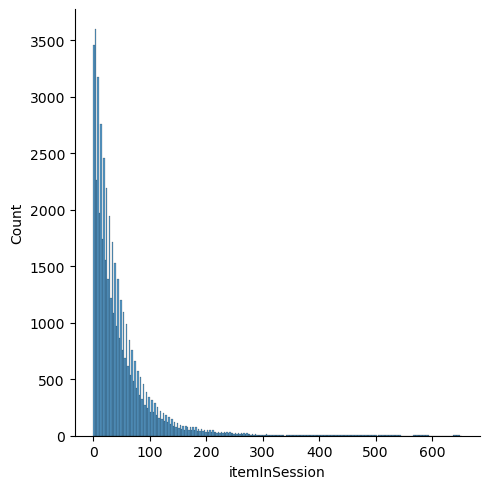

In [22]:
free_item_in_session = df.filter(col("level") == "free").toPandas()

sns.displot(free_item_in_session['itemInSession'])

In [23]:
df.groupby("level").agg(avg("itemInSession")).show()

+-----+------------------+
|level|avg(itemInSession)|
+-----+------------------+
| free|46.130363776673065|
| paid|132.12624475684814|
+-----+------------------+



### We can see that users who have a paid subscription have more items in sessions, which probably means that they like the app and are heavy users.

In [24]:
non_churn_item_in_session = (
    df.select("itemInSession").filter(col("churn") == 0).toPandas()
)

churn_item_in_session = df.select("itemInSession").filter(col("churn") == 1).toPandas()

In [25]:
non_churn_item_in_session.describe()

,itemInSession
count,233290.000000
mean,115.988847
std,131.150670
min,0.000000
25%,27.000000
50%,71.000000
75%,159.000000
max,1321.000000


In [26]:
churn_item_in_session.describe()

,itemInSession
count,44864.000000
mean,109.232993
std,122.721709
min,0.000000
25%,26.000000
50%,66.000000
75%,147.000000
max,889.000000


### Item in Sessions are pretty similar between churn and non churn users.

## Length

<Axes: >

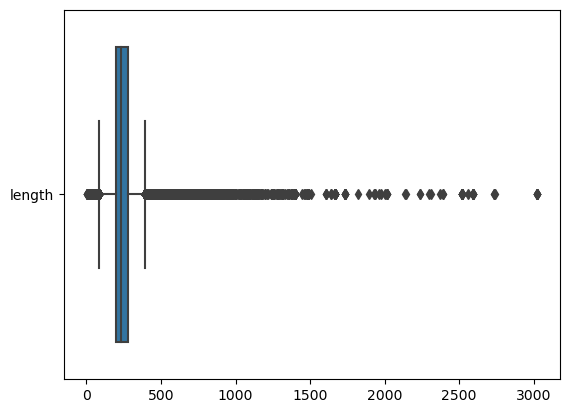

In [27]:
df_length = df.select("length").toPandas().dropna()

sns.boxplot(df_length, orient='h')

In [28]:
df_length.describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


In [29]:
df_length_non_churn = df.select("length").filter(col("churn") == 0).toPandas().dropna()

df_length_churn = df.select("length").filter(col("churn") == 1).toPandas().dropna()

In [30]:
df_length_non_churn.describe()

,length
count,191714.000000
mean,249.209135
std,98.625883
min,0.783220
25%,199.940770
50%,234.657510
75%,277.158730
max,3024.665670


In [31]:
df_length_churn.describe()

,length
count,36394.000000
mean,248.632796
std,102.384977
min,4.048530
25%,199.392200
50%,233.899950
75%,275.630567
max,3024.665670


### The length of the music that churn and non churn users are similar too.

## Gender

In [32]:
df\
.groupBy("churn", "gender")\
.agg(countDistinct("userId").alias("users_total"))\
.orderBy(["churn", "gender"], ascending=[False, True])\
.show()

+-----+------+-----------+
|churn|gender|users_total|
+-----+------+-----------+
|    1|     F|         20|
|    1|     M|         32|
|    0|     F|         84|
|    0|     M|         89|
+-----+------+-----------+



## Artist

/home/rafael.silva/anaconda3/envs/sparkify/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


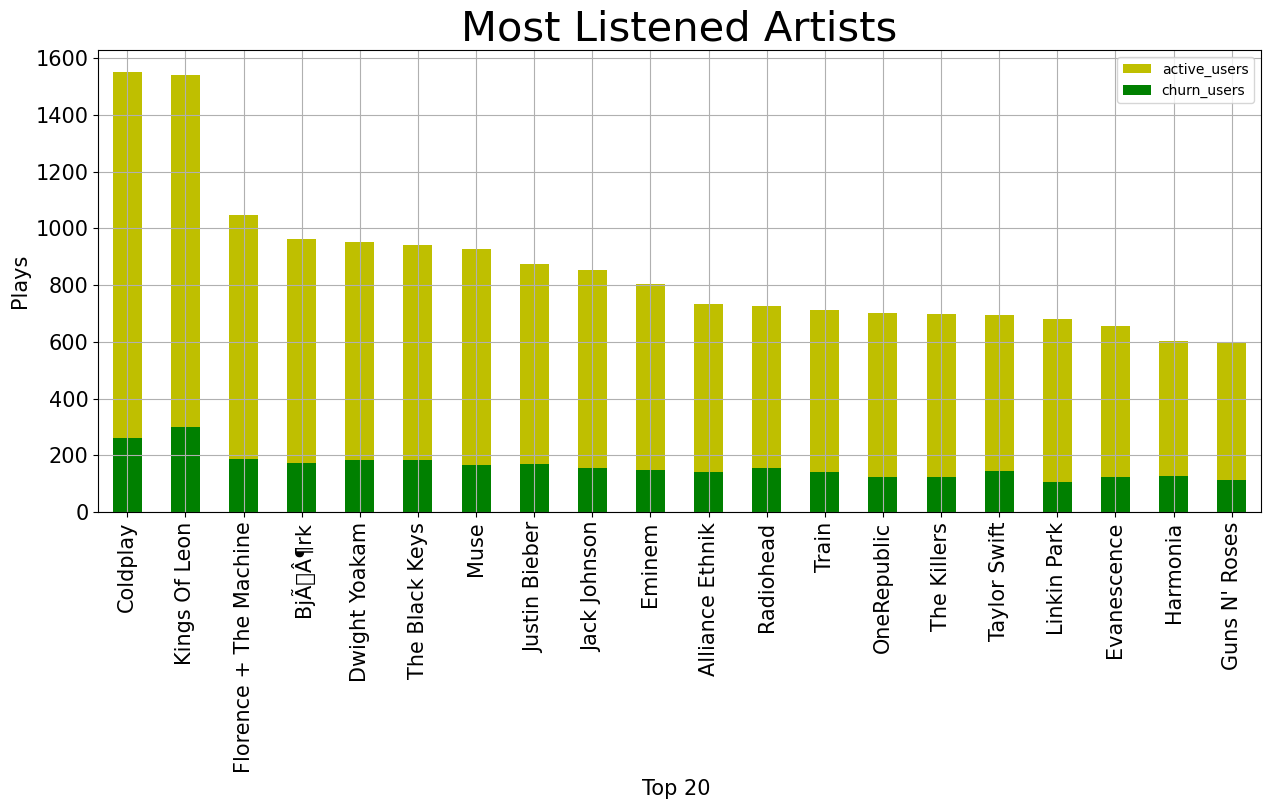

In [33]:
artist_churn = df.filter(col("churn") == 1).groupby('artist').count().toPandas().dropna()
artist_non_churn = df.filter(col("churn") == 0).groupby('artist').count().toPandas().dropna()

artist_churn = artist_churn.rename(columns={"count": "churn_users"})
artist_non_churn= artist_non_churn.rename(columns={"count": "active_users"}) 

artist_churn = artist_churn.set_index('artist')   
artist_non_churn= artist_non_churn.set_index('artist')  

df_artist= pd.concat([artist_churn, artist_non_churn], axis=1, join="outer", sort=True)

df_artist = df_artist.sort_values(by=['active_users', 'churn_users'], ascending=False)

df_artist = df_artist.head(20)
plt.title('Most Listened Artists', fontsize=30)

ax = df_artist['active_users'].plot(kind='bar', figsize=(15, 6), color ='y', legend=True, fontsize=15)
ax = df_artist['churn_users'].plot(kind='bar', legend=True, color='g', fontsize=15) 
ax.set_xlabel("Top 20 ", fontsize=15)
ax.set_ylabel("Plays", fontsize=15)
plt.grid(True)
plt.show()

## Location

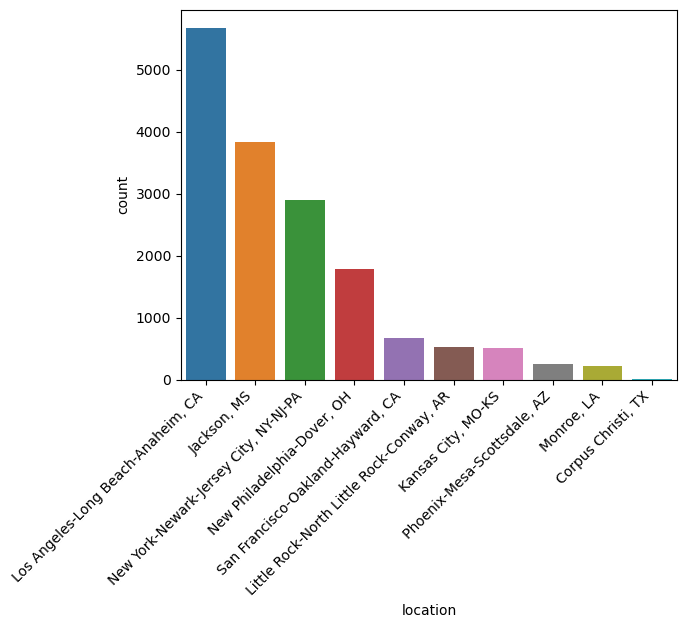

In [34]:
churn_location = (
    df
    .filter(col("churn") == 1)
    .groupBy("location")
    .count()
)

churn_location = churn_location.toPandas().head(10).sort_values(by = "count", ascending = False)

#plt.figure(figsize=(15,10))

my_plot = sns.barplot(data=churn_location, x="location", y="count")

_ = my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')

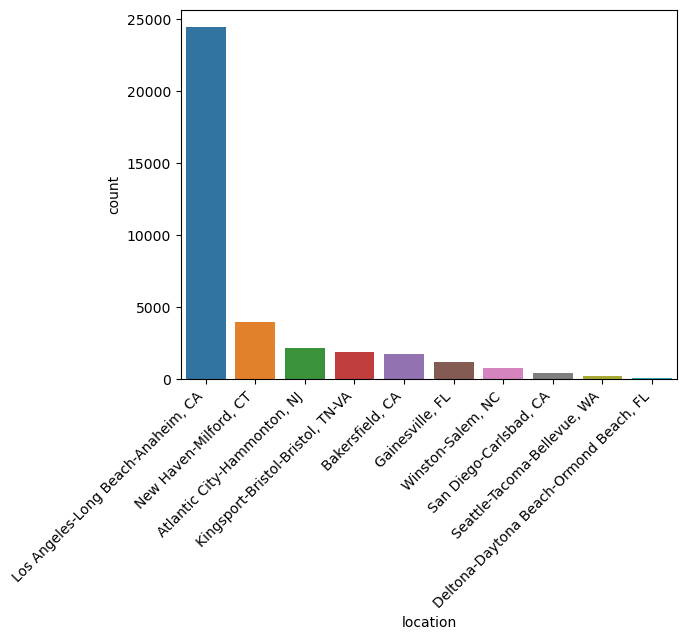

In [35]:
non_churn_location = (
    df
    .filter(col("churn") == 0)
    .groupBy("location")
    .count()
)

non_churn_location = non_churn_location.toPandas().head(10).sort_values(by = "count", ascending = False)

my_plot = sns.barplot(data=non_churn_location, x="location", y="count")


_ = my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,horizontalalignment='right')

In [36]:
# page_counts = df.groupBy("userId")\
#     .agg(
#         max("churn").alias("churn"),
#         count(when(col("page") == 'Thumbs Up', 1)).alias("thumbs_up"),
#         count(when(col("page") == 'Home', 1)).alias("home"),
#         count(when(col("page") == 'Add to Playlist', 1)).alias("playlist_count"),
#         count(when(col("page") == 'Add Friend', 1)).alias("friends"),
#         count(when(col("page") == 'Roll Advert', 1)).alias("advert"),
#         count(when(col("page") == 'Logout', 1)).alias("logout"),
#         count(when(col("page") == 'Thumbs Down', 1)).alias("thumbs_down"),
#         count(when(col("page") == 'Downgrade', 1)).alias("downgrade"),
#         count(when(col("page") == 'Settings', 1)).alias("settings"),
#         count(when(col("page") == 'Help', 1)).alias("help"),
#         count(when(col("page") == 'About', 1)).alias("about"),
#         count(when(col("page") == 'Upgrade', 1)).alias("upgrade"),
#         count(when(col("page") == 'Save Settings', 1)).alias("save_settings"),
#         count(when(col("page") == 'Error', 1)).alias("error"),
#         count(when(col("page") == 'Submit Upgrade', 1)).alias("submit_upgrade"),
#         count(when(col("page") == 'Submit Downgrade', 1)).alias("submit_downgrade"),
#         countDistinct("sessionId").alias("session_count"),
#         max("days_of_membership").alias("membership_days")
#     )

# df_model = page_counts.groupBy("churn")\
#     .agg(
#         round(avg("thumbs_up"), 2).alias("thumbs_up"),
#         round(avg("home"), 2).alias("home"),
#         round(avg("playlist_count"), 2).alias("playlist_count"),
#         round(avg("friends"), 2).alias("friends"),
#         round(avg("advert"), 2).alias("advert"),
#         round(avg("logout"), 2).alias("logout"),
#         round(avg("thumbs_down"), 2).alias("thumbs_down"),
#         round(avg("downgrade"), 2).alias("downgrade"),
#         round(avg("settings"), 2).alias("settings"),
#         round(avg("help"), 2).alias("help"),
#         round(avg("about"), 2).alias("about"),
#         round(avg("upgrade"), 2).alias("upgrade"),
#         round(avg("save_settings"), 2).alias("save_settings"),
#         round(avg("error"), 2).alias("error"),
#         round(avg("submit_upgrade"), 2).alias("submit_upgrade"),
#         round(avg("submit_downgrade"), 2).alias("submit_downgrade"),
#         round(avg("session_count"), 2).alias("session_count"),
#         round(avg("membership_days"),2 ).alias("membership_days")
#     ).toPandas()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [37]:
df_feat_eng = df.groupBy("userId")\
    .agg(
        max("churn").alias("label"),
        count(when(col("page") == 'Error', 1)).alias("error_count"),
        count(when(col("page") == 'Add Friend', 1)).alias("friends_count"),
        count(when(col("page") == 'Roll Advert', 1)).alias("advert_count"),
        count(when(col("page") == 'Add to Playlist', 1)).alias("playlist_count"),
        count(when(col("page") == 'Thumbs Up', 1)).alias("thumbs_up"),
        count(when(col("page") == 'Thumbs Down', 1)).alias("thumbs_down"),
        count(when(col("page") == 'Downgrade', 1)).alias("downgrade"),
        count(when(col("page") == 'Upgrade', 1)).alias("upgrade"),
        count(when(col("page") == 'Submit Upgrade', 1)).alias("submit_upgrade"),
        count(when(col("page") == 'Submit Downgrade', 1)).alias("submit_downgrade"),
        (when(first("level") == 'free', 1).otherwise(0)).alias("first_level_free"),
        (when(first("level") == 'paid', 1).otherwise(0)).alias("fist_level_paid"),
        (when(last("level") == 'free', 1).otherwise(0)).alias("last_level_free"),
        (when(last("level") == 'paid', 1).otherwise(0)).alias("last_level_paid"),
        max("days_of_membership").alias("membership_days"),
        countDistinct("sessionId").alias("session_count")
    ).drop("userId")

In [38]:
df_feat_eng.show()

+-----+-----------+-------------+------------+--------------+---------+-----------+---------+-------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+
|label|error_count|friends_count|advert_count|playlist_count|thumbs_up|thumbs_down|downgrade|upgrade|submit_upgrade|submit_downgrade|first_level_free|fist_level_paid|last_level_free|last_level_paid|membership_days|session_count|
+-----+-----------+-------------+------------+--------------+---------+-----------+---------+-------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+
|    0|          3|           49|          25|            61|      148|         27|       30|      1|             1|               1|               0|              1|              0|              1|             64|           35|
|    1|          0|            3|          18|             3|        7|          3| 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
training, test = df_feat_eng.randomSplit([0.8, 0.2], seed=42)

In [40]:
feature_columns = df_feat_eng.columns
feature_columns.remove('label')

assembler = VectorAssembler(inputCols=[*feature_columns], outputCol="input_features")

In [41]:
scaler = Normalizer(inputCol="input_features", outputCol="features")

In [43]:
def classification_report(df):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
    for metric in metrics:
        evaluator.setMetricName(metric)
        print(f"{metric}: {evaluator.evaluate(df)}")

## Logistic Regression

In [45]:
lr =  LogisticRegression()
pipeline_lr  = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline_lr.fit(training)
lr_predictions = lr_model.transform(test)

23/09/06 21:53:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/06 21:53:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [46]:
classification_report(lr_predictions)

accuracy: 0.72
weightedPrecision: 0.68
weightedRecall: 0.72
f1: 0.678


In [64]:
lr_param_grid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10, 50, 100, 1000])\
.build()

lr_cross_val = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=lr_param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
lr_model_cv = lr_cross_val.fit(training)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
lr_model_cv_predictions = lr_model_cv.transform(test)

In [65]:
classification_report(lr_model_cv_predictions)

accuracy: 0.72
weightedPrecision: 0.68
weightedRecall: 0.72
f1: 0.678


## Random Forest

In [49]:
rf =  RandomForestClassifier()
pipeline_rf  = Pipeline(stages=[assembler, scaler, rf])

rf_model = pipeline_rf.fit(training)
rf_predictions = rf_model.transform(test)

In [50]:
classification_report(rf_predictions)

accuracy: 0.78
weightedPrecision: 0.784
weightedRecall: 0.7799999999999999
f1: 0.7401169590643275


In [57]:
rf_param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 25])
             .addGrid(rf.numTrees, [5, 25, 50])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline_rf,
                      estimatorParamMaps = rf_param_grid,
                      evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                      numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
rf_model_cv = rfcv.fit(training)
rf_model_cv_predictions = rf_model_cv.transform(test)

In [58]:
classification_report(rf_model_cv_predictions)

accuracy: 0.78
weightedPrecision: 0.784
weightedRecall: 0.7799999999999999
f1: 0.7401169590643275


## GBTClassifier

In [53]:
gbt =  GBTClassifier()
pipeline_gbt  = Pipeline(stages=[assembler, scaler, gbt])

gbt_model = pipeline_gbt.fit(training)
gbt_predictions = gbt_model.transform(test)

In [54]:
classification_report(gbt_predictions)

accuracy: 0.68
weightedPrecision: 0.616969696969697
weightedRecall: 0.68
f1: 0.632


In [55]:
gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 4, 6])
    .addGrid(gbt.maxIter, [10, 20])
    .addGrid(gbt.stepSize, [0.1, 0.01])
    .build()
)

# Create 5-fold CrossValidator
gbtcv = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=MulticlassClassificationEvaluator(metricName="f1"),
    numFolds=5,
)

# Run cross-validation, and choose the best set of parameters.
gbt_model_cv = gbtcv.fit(training)
gbt_model_cv_predictions = gbt_model_cv.transform(test)

In [56]:
classification_report(gbt_model_cv_predictions)

accuracy: 0.7
weightedPrecision: 0.64
weightedRecall: 0.7000000000000001
f1: 0.6456140350877193


## SVM

In [60]:
svc =  LinearSVC()
pipeline_svc  = Pipeline(stages=[assembler, scaler, svc])

svc_model = pipeline_svc.fit(training)
svc_predictions = svc_model.transform(test)

In [61]:
classification_report(svc_predictions)

accuracy: 0.72
weightedPrecision: 0.5184
weightedRecall: 0.72
f1: 0.6027906976744185


In [63]:
from pyspark.ml.classification import NaiveBayes
nb =  NaiveBayes()

pipeline_nb  = Pipeline(stages=[assembler, scaler, nb])

nb_model = pipeline_nb.fit(training)
nb_predictions = nb_model.transform(test)

classification_report(nb_predictions)

23/09/07 10:41:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
accuracy: 0.72
weightedPrecision: 0.5184
weightedRecall: 0.72
f1: 0.6027906976744185


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.